In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
def one_hot_eyewitness(df):
    # Get one hot encoding of columns 'eyewitnessed'
    one_hot = pd.get_dummies(df['eyewitnessed'])
    # Drop column 'eyewitnessed' as it is now encoded
    df = df.drop('eyewitnessed',axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    return df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df = one_hot_eyewitness(pd.read_csv('datasets/datasets-eyewitness/EyewitnessTweetsFromCrisisT26/CrisisLexT26_FloodsTraining_EN.csv'))
test_df = one_hot_eyewitness(pd.read_csv('datasets/datasets-eyewitness/EyewitnessTweetsFromCrisisT26/CrisisLexT26_FloodsTest_EN.csv'))

# train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,Eyewitness,NotEyewitness
0,Philippine floods worsen as death toll hits 14...,0,1
1,RT @gmanews: Philippine floods worsen as death...,0,1
2,4 Luzon dams release water; flood warning up: ...,0,1
3,RT @ANCALERTS: PAGASA 8:50pm advisory: Yellow ...,0,1
4,@ANCALERTS: PAGASA 8:50pm advisory: Yellow war...,0,1


In [3]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df['Eyewitness'], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df['Eyewitness'], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df['Eyewitness'], shuffle=False)

In [4]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [5]:
os.system('rm -rf /tmp/tf')

# Create the estimator
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.01,
      l1_regularization_strength=0.03
    ),
    model_dir='/tmp/tf')

In [6]:
# Train the estimator
estimator.train(input_fn=train_input_fn, steps=10000);

In [7]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.980226993560791
Test set accuracy: 0.827327311038971


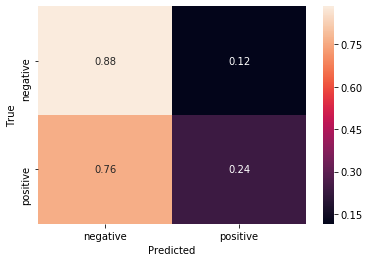

In [8]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(test_df["Eyewitness"], 
                           get_predictions(estimator, predict_test_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");